# Multi-looking level

Code used to analyse the effect of multi-looking on sensitivity of TDX phase height to selective logging

In [1]:
import xarray as xr
import os 
import glob
from matplotlib import pyplot as plt
import numpy as np
import rioxarray as rx
import geopandas as gpd
from datetime import datetime as dt
import pandas as pd
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import stats

# Get TDX derived DEMs ------------------------------------
DEM_dir = '/disk/scratch/local.4/harry/DEM/NC/merged/subset/'
files = glob.glob(DEM_dir+'*.nc')
f_per = [f for f in files if 'PER' in f]
f_gab = [f for f in files if 'GAB' in f]
f_gabA = [f for f in f_gab if '_A_' in f]
f_gabD = [f for f in f_gab if '_D_' in f]

# Get forest inventory data --------------------------------------------------------
INVENTORY_dir='/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/Forest_inventory/'
g_df = pd.read_csv(INVENTORY_dir+'GabonPlots.csv',index_col='Plot')
p_df = pd.read_csv(INVENTORY_dir+'PeruPlots.csv',index_col='Plot')

# Get plot shapefiles -------------------------------------------
SHP_dir='/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/core_plot_shapefiles/'
shps = gpd.read_file(SHP_dir+'core_plots_10mBuffer.shp')
#shps_nobuff = gpd.read_file(SHP_dir+'core_plots.shp')
shps_bg = gpd.read_file(SHP_dir+'background_plots.shp')

In [2]:
# Convenience routines ----------

def open_ds(dataset,looks):
    # Open net_cdf file ready to be cropped using rio
    filename = [x for x in dataset if '_ML'+str(looks)+'_' in x][0]
    try:
        ds = xr.open_dataset(filename).drop(['metadata','crs']).rio.write_crs('EPSG:4326')
    except:
        ds = xr.open_dataset(filename).rio.write_crs('EPSG:4326')
    return ds

def crop(ds,plot,all_touched=False):
    # Crop an xarray object 'ds' to plot
    # plot is a string e.g. 'PC1' or 'GC4'
    # pass all_touched = True to include pixels that partially intersect the plot
    ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    if 'B' in plot:
        shape = shps_bg[shps_bg.layer==plot].geometry
    else:
        shape = shps[shps.layer==plot].geometry
    return ds.rio.clip(shape,all_touched=all_touched)

In [22]:
def get_dh_dagb(changeMap,plotting,color='black',label=''):
    """
    Takes a map of phase height change
    Makes a visualiation if plotting==True
    Returns:
    - plot level change in phase height for selective logging plots
    - corresponding AGB losses in those plots
    - uncertainties in those AGB losses
    - changes in phase height for 1 ha control plots
    """
    q = changeMap.mean()
    DH_list= []
    control = []
    DAGB_list = []
    error_list = []
    j=0
    for plot in ['GC'+i for i in ['1','2','3','4']]:
        DH = crop(changeMap,plot,all_touched=True).mean() - q
        DAGB = -g_df['AGB_loss'][plot]
        DAGB_err = g_df['dAGB_loss'][plot]

        error_list.append(DAGB_err)
        DH_list.append(DH)
        DAGB_list.append(DAGB)
        if plotting == True:
            if j >0: label=None
            plt.plot(DAGB,DH,'o',color=color,label=label)
            plt.errorbar(DAGB,DH,
                         xerr=DAGB_err,
                         yerr=[0.63,0.43,0.42,0.52][j], # imported from cell at end of workbook
                         color=color)
            #plt.annotate(plot,xy=(DAGB-0.5,DH+0.1))
        j+=1
    for plot in ['GB'+str(i) for i in range(1,12)]:
        DH = crop(changeMap,plot,all_touched=True).mean() -q
        control.append(DH)
    return DH_list, DAGB_list, error_list, control

In [36]:
def changeMapBoth(LOOKS,plotting=False,color=None,label=None):
    """
    Obtains statistics for a particular level of multilooking
    LOOKS is integer number of range looks 
    """
    reference = open_ds(f_gabA,3)
    ascending = open_ds(f_gabA,LOOKS).interp(lat=reference.lat,lon=reference.lon,method='nearest')
    descending = open_ds(f_gabD,LOOKS).interp(lat=reference.lat,lon=reference.lon,method='nearest')
    ds = xr.concat([ascending,descending],dim='t').sortby('t')
    before = ds.height.isel(t=[0,1,2,3]).mean(dim='t')
    after = ds.height.isel(t=[4,5,6,7]).mean(dim='t')
    changeMap = after - before
    q = changeMap.mean()
    DH_list, DAGB_list, DAGB_err_list,control = get_dh_dagb(changeMap,plotting=plotting,color=color,label=label)
#     if plotting == True:
#         plt.plot(DAGB_list,DH_list,'s',color='black',ls='none')
#         plt.errorbar(DAGB_list,DH_list,xerr=DAGB_err_list,color='black',ls='none')
    control_std = np.array(control).std()
    slope, intercept, r, p, se = stats.linregress(DAGB_list,DH_list)
    def best_fit(dagb):
        return intercept + slope*dagb
    if plotting == True:
        plt.plot(np.linspace(-140,0),best_fit(np.linspace(-140,0)),color='grey',zorder=1)
        plt.axhline(y=0,color='black',zorder=1,lw=1,ls='--')
        plt.xlim(right=0)
        #plt.axvline(x=0,color='black',zorder=1,lw=1,ls='-')
        plt.xlabel('$\Delta$AGB (Mg)')
        plt.ylabel('$\Delta h_\phi$ - regional average (m)')
        #plt.title('Combined Ascending and Descending Passes')
        #plt.savefig('/home/s1332488/chapter1/dH_vs_dAGB_'+str(LOOKS)+'Looks_AscDesCombined.png',dpi=300)
        #plt.show()    
    return pd.Series({'looks':LOOKS,
                      'slope':slope, # Slope is linear coefficient of best fit line
                      'r': r,  # correlation coefficient
                      #'sensitivity':float(sensitivity),
                      'p':p, # p-value
                      'se':se, # standard error
                     'control_std':control_std}) # std-dev of control plots

In [6]:
# Collate stats for different levels of multi-looking

df_stats = pd.DataFrame(columns=['looks','slope','r','p','se','control_std'])
for L in [int(f.split('ML')[1].split('_')[0]) for f in f_gabD]:
    df_stats = df_stats.append(changeMapBoth(L),ignore_index=True)
df_stats = df_stats.sort_values('looks')
df_stats['slope_cm'] = 100*df_stats.slope

In [7]:
df_stats

,looks,slope,r,p,se,control_std,slope_cm
0,3.0,0.023499,0.995879,0.004121,0.001513,0.664560,2.349911
7,4.0,0.020876,0.995858,0.004142,0.001348,0.735245,2.087646
1,5.0,0.020319,0.974736,0.025264,0.003292,0.801810,2.031863
9,6.0,0.019622,0.993722,0.006278,0.001562,0.828796,1.962159
11,7.0,0.017684,0.935635,0.064365,0.004717,0.789454,1.768447
12,8.0,0.018792,0.932815,0.067185,0.005133,0.903813,1.879154
13,9.0,0.019561,0.988287,0.011713,0.002136,0.848959,1.956143
6,10.0,0.016161,0.945065,0.054935,0.003953,0.922651,1.616141
4,12.0,0.021050,0.960115,0.039885,0.004335,0.982771,2.104995
14,14.0,0.016033,0.987696,0.012304,0.001795,1.001519,1.603295


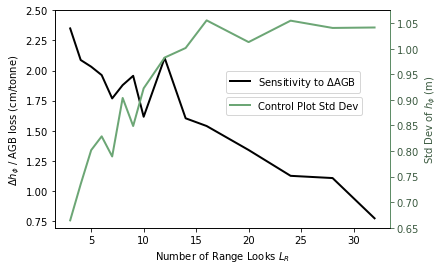

In [8]:
ax=plt.axes()
ax2=ax.twinx()
df_stats.plot(x='looks',y='control_std',ax=ax2,label='Control Plot Std Dev',marker='None',lw=2,color='#6ca675')
df_stats.plot(x='looks',y='slope_cm',marker='None',color='black',ax=ax,label='Sensitivity to $\Delta$AGB',lw=2)
ax.legend(loc=(0.51,0.62))
ax.set_ylabel('$\Delta h_\phi$ / AGB loss (cm/tonne)')
ax2.set_ylabel('Std Dev of $h_\phi$ (m)',color='#3a593f')
ax.set_xlabel('Number of Range Looks $L_R$')
ax2.set_ylim(0.65)
ax.set_ylim(top=2.5)
ax2.legend(loc=(0.51,0.52))
ax2.spines["right"].set_color('#6ca675')
ax2.tick_params(axis='y', colors='#3a593f')
plt.savefig('/home/s1332488/chapter1/Nlooks.png',dpi=300)

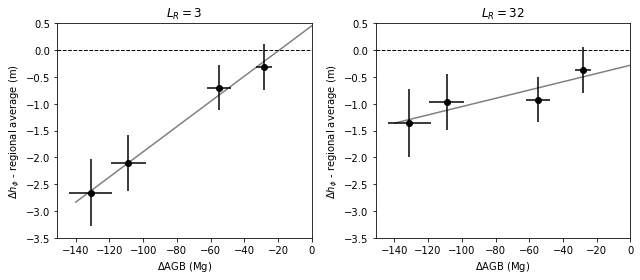

In [39]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title('$L_R = 3$')
changeMapBoth(3,plotting=True,color='black',label='L$_R$=3')
plt.ylim(-3.5,0.5)
plt.subplot(1,2,2)
plt.title('$L_R = 32$')
changeMapBoth(32,plotting=True,color='black',label='L$_R$=32')
plt.ylim(-3.5,0.5)
plt.tight_layout()
#plt.legend()
plt.savefig('/home/s1332488/chapter1/dH_vs_dAGB_3vs32LOOKs.png',dpi=300)

In [53]:
reference = open_ds(f_gabA,3)
ascending = open_ds(f_gabA,3).interp(lat=reference.lat,lon=reference.lon,method='nearest')
descending = open_ds(f_gabD,3).interp(lat=reference.lat,lon=reference.lon,method='nearest')
ds = xr.concat([ascending,descending],dim='t').sortby('t')

In [55]:
ds

<xarray.Dataset>
Dimensions:      (lat: 655, lon: 1213, t: 8)
Coordinates:
  * t            (t) datetime64[ns] 2019-11-30T04:57:08 ... 2020-02-15T04:57:05
    spatial_ref  int64 0
  * lat          (lat) float64 -0.1279 -0.1279 -0.128 ... -0.1604 -0.1605
  * lon          (lon) float64 12.24 12.24 12.24 12.24 ... 12.3 12.3 12.3 12.3
Data variables:
    height       (t, lat, lon) float64 nan nan nan nan ... 4.466 2.284 3.6 2.912
    coh          (t, lat, lon) float64 nan nan nan nan ... 0.7846 0.7665 0.7487
    elevation    (t, lat, lon) float32 nan nan nan nan ... 372.6 372.5 372.3
    h_amb        (t) int64 54 64 72 80 91 86 101 93
Attributes:
    grid_mapping:  spatial_ref

In [75]:
# Error estimation for 3 Look height change

ds['h_amb'] = xr.DataArray(data=[54,64,72,80,91,86,101,93],
            dims=['t'],
            coords=dict(t=ds.t))

ds['error'] = ds.h_amb * np.sqrt((1-ds.coh**2) / (18*ds.coh**2)) / (2*np.pi)

def get_h_err(plot):
    p = crop(ds.error,plot)
    size = p.lat.size * p.lon.size
    spatial_error = p.mean(dim=['lat','lon'])/np.sqrt(size)
    return np.sqrt((spatial_error**2).sum())

for plot in ['GC1','GC2','GC3','GC4']:
    print(plot)
    print(get_h_err(plot).values)
    

GC1
0.6317706847309634
GC2
0.42777540598257974
GC3
0.42362039382138705
GC4
0.5158137294040798
